In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
from random import shuffle
import scipy.interpolate as interp
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [16]:
def data2matrix():
    df2 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv')
    df = df2.copy()    
    #remove indexing in features 
    df = df.drop(['No'], axis=1)
    df = df.drop(['year'], axis=1)
    df = df.drop(['month'], axis = 1)
    df = df.drop(['day'], axis=1)
    #df = df.drop(['Is'], axis = 1)
    #df = df.drop(['Ir'], axis = 1)

    for i in range(1,9): 

        df['pm2.5_%d' %i] = df2['pm2.5'].shift(i)
        df['DEWP_%d' %i] = df2['DEWP'].shift(i)
        df['TEMP_%d' %i] = df2['TEMP'].shift(i)
        df['PRES_%d' %i] = df2['PRES'].shift(i)
        df['cbwd_%d' %i] = df2['cbwd'].shift(i)
        df['Iws_%d' %i] = df2['Iws'].shift(i)
        df['Is_%d' %i] = df2['Is'].shift(i)
        df['Ir_%d' %i] = df2['Ir'].shift(i)
        
    df = df[df.hour ==8] 
    #shift tomorrow's pm2.5 data into today's row
    df['pm2.5_to_predict'] = df['pm2.5'].shift(-1) 
    df = df.drop(['hour'], axis=1)
    #produce an numpy array
    df = df.dropna(how='any')
    data = np.matrix(df) 
    N = len(data)
    #Wind direction is on column 
    for i in range (N):
            for p in range(data.shape[1]):
                if data[i,p] == 'NE':
                    data[i,p] = 1
                elif data[i,p] == 'SE':
                    data[i,p] = 2
                elif data[i,p] == 'NW':
                    data[i,p] = 4
                elif data[i,p] == 'cv':
                    data[i,p] = 0
                    
    data = data.astype(float)
    del N, i, df2, p    
    return data

In [17]:
d=data2matrix()

In [18]:
d.shape

(1651, 73)

In [19]:
y = d[:,0]

In [20]:
y.shape

(1651, 1)

In [22]:
x=d[:,1:72]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True)

In [28]:
def norm(x):
  return np.linalg.norm(x) 
normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

In [83]:
def build_model():
  model = k.Sequential([
    k.layers.Dense(64, activation='relu', input_shape=(71,)),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse','acc'])
  return model

In [54]:
model = build_model()

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                4608      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [56]:
example_batch = X_train[:10]
example_result = model.predict(example_batch)
example_result

array([[304.9616 ],
       [313.4895 ],
       [316.78464],
       [315.84726],
       [319.81445],
       [314.66272],
       [309.09827],
       [307.65024],
       [289.11243],
       [319.01566]], dtype=float32)

In [58]:
class PrintDot(k.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  X_train, y_train,epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [71]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,142.851208,8.276126,142.851212,535.026390,17.330921,535.026428,995
996,137.370528,8.263455,137.370529,355.322103,13.477231,355.322083,996
997,138.543515,8.231608,138.543518,360.606447,13.215087,360.606445,997
998,139.845135,8.373123,139.845139,348.109771,13.451520,348.109802,998
999,143.892349,8.501762,143.892349,404.096678,14.286578,404.096680,999


In [72]:
hist.head()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,5868.718314,53.938610,5868.718262,1651.646864,31.260431,1651.646729,0
1,2722.100135,41.787022,2722.099854,2465.168054,41.762913,2465.167969,1
2,2230.772190,37.058468,2230.772461,946.254814,23.124636,946.254883,2
3,2114.492332,36.960583,2114.492188,4625.357037,61.313339,4625.356934,3
4,1727.234934,32.255329,1727.234863,730.170911,19.913754,730.170898,4


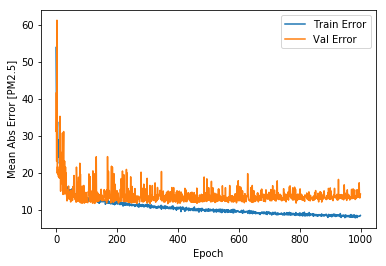

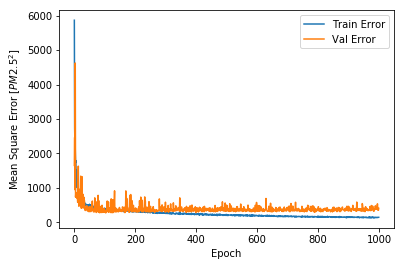

In [78]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [PM2.5]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$PM2.5^2$]')
  plt.plot(hist['epoch'], hist['loss'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)


....................................

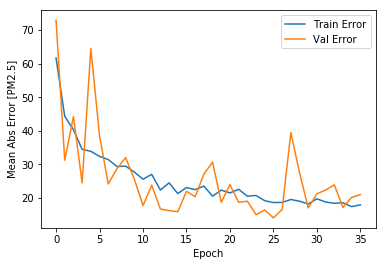

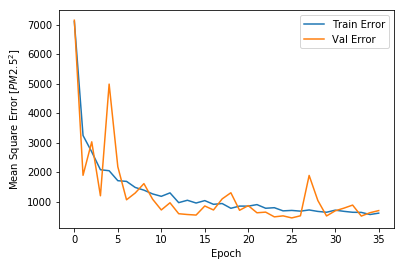

In [84]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = k.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [85]:
model.evaluate(X_test, y_test)

331/331 [==============================] - 0s 45us/sample - loss: 782.3452 - mean_absolute_error: 23.0933 - mean_squared_error: 782.3453 - acc: 0.0000e+00


[782.345249879036, 23.093285, 782.3453, 0.0]